In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
os.getcwd() 

'/Users/masanoritakahashi/Documents/aqi/modefieddata'

In [60]:
! ls

EDA_for_timeseriesdata.ipynb
alipur_delhi.csv
conbind_modefieddata-ARIMA.ipynb
conbind_modefieddata-Prophet.ipynb
conbind_modefieddata-単変量XGboost_予測値で予測.ipynb
conbind_modefieddata.ipynb
indirapuram_ghaziabad.csv
mduni_rohtak.csv
murthal_sonipat.csv
rohini_1015.csv
sector125_noida.csv
sector16a_faridabad.csv


In [61]:
files = glob.glob("/Users/masanoritakahashi/Documents/aqi/modefieddata/*.csv")

In [62]:
df_pm25=pd.DataFrame(columns=[""])
for file in files:
    df=pd.read_csv(file, usecols=[1])
    df_pm25=pd.concat([df_pm25, df], axis=1)
    
df_pm25=df_pm25.iloc[:,1:]

In [63]:
tmp_time=pd.date_range(start='2019-09-20 00:00', end='2019-10-04 8:00', freq='H').strftime('%Y-%m-%d %H:%M:%S')
df_tmp_time=pd.DataFrame(tmp_time, columns=["utc"])
df_pm25["utc"]=pd.to_datetime(df_tmp_time["utc"])

In [64]:
df_pm25.head()

,alipur,faridabad,ghaziabad,rohtak,noida,sonipat,rohini,utc
0,56.0,NaN,NaN,NaN,NaN,NaN,19.0,2019-09-20 00:00:00
1,69.0,NaN,NaN,NaN,NaN,NaN,27.0,2019-09-20 01:00:00
2,69.0,NaN,NaN,NaN,NaN,NaN,13.0,2019-09-20 02:00:00
3,64.0,NaN,NaN,NaN,NaN,NaN,9.0,2019-09-20 03:00:00
4,56.0,NaN,NaN,NaN,NaN,NaN,12.0,2019-09-20 04:00:00


## 可視化

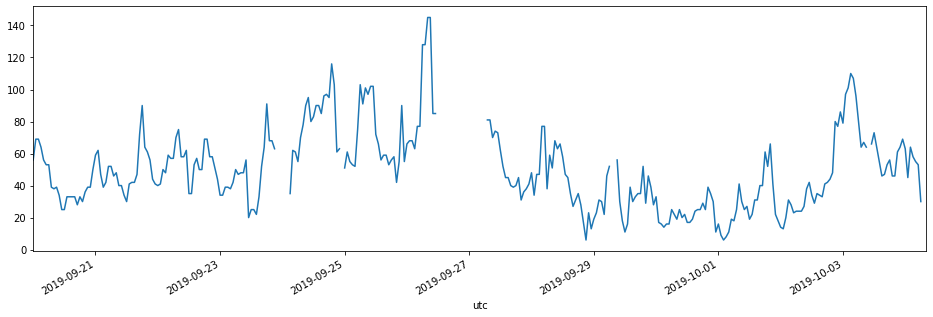

In [65]:
values = pd.Series(df_pm25["alipur"], dtype="float")
values.index= pd.to_datetime(df_pm25["utc"])
plt.figure(figsize=(16, 5))
values.plot()

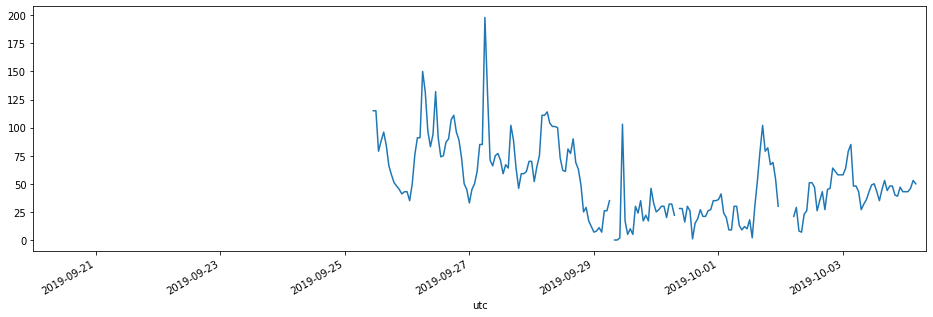

In [66]:
values = pd.Series(df_pm25["faridabad"], dtype="float")
values.index= pd.to_datetime(df_pm25["utc"])
plt.figure(figsize=(16, 5))
values.plot()

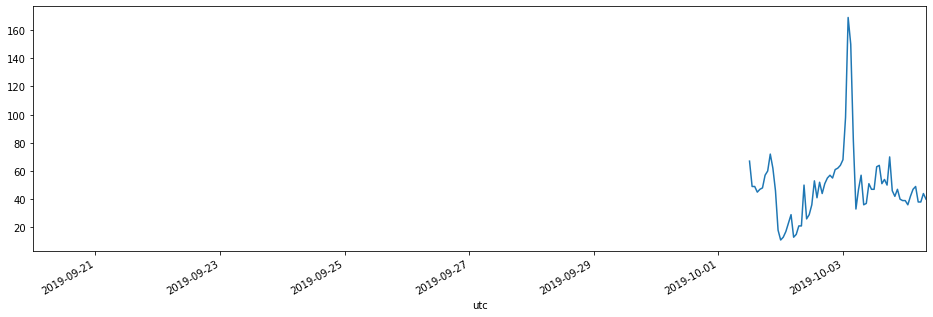

In [67]:
values = pd.Series(df_pm25["ghaziabad"], dtype="float")
values.index= pd.to_datetime(df_pm25["utc"])
plt.figure(figsize=(16, 5))
values.plot()

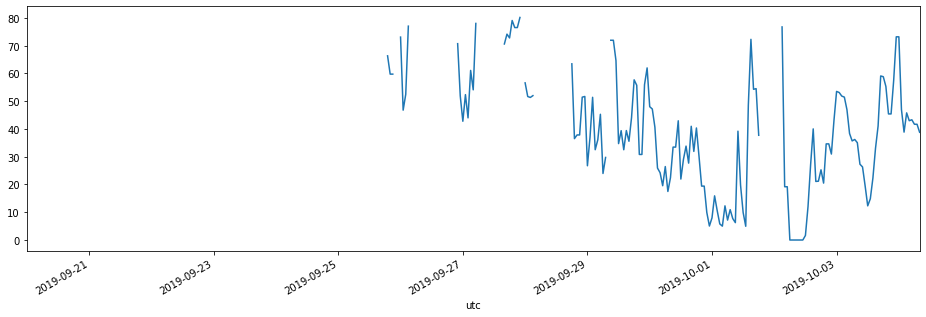

In [68]:
values = pd.Series(df_pm25["rohtak"], dtype="float")
values.index= pd.to_datetime(df_pm25["utc"])
plt.figure(figsize=(16, 5))
values.plot()

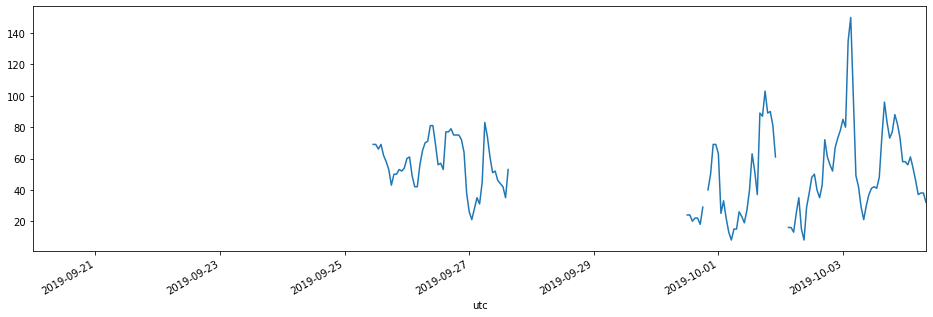

In [69]:
values = pd.Series(df_pm25["noida"], dtype="float")
values.index= pd.to_datetime(df_pm25["utc"])
plt.figure(figsize=(16, 5))
values.plot()

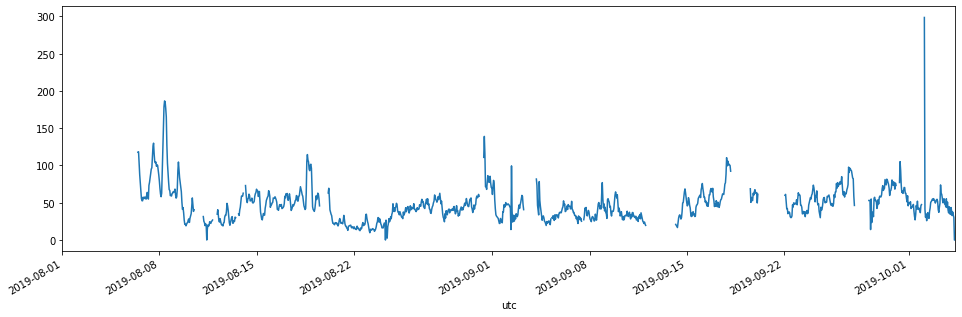

In [35]:
values = pd.Series(df_pm25["sonipat"], dtype="float")
values.index= pd.to_datetime(df_pm25["utc"])
plt.figure(figsize=(16, 5))
values.plot()

In [25]:
#可視化の結果より使用データを2019-08-20 ~ 2019-09-30にする

In [26]:
#欠損値補完
for col in df_pm25.columns[:-1] :
    df_pm25["{}".format(col)]=df_pm25["{}".format(col)].interpolate('linear')

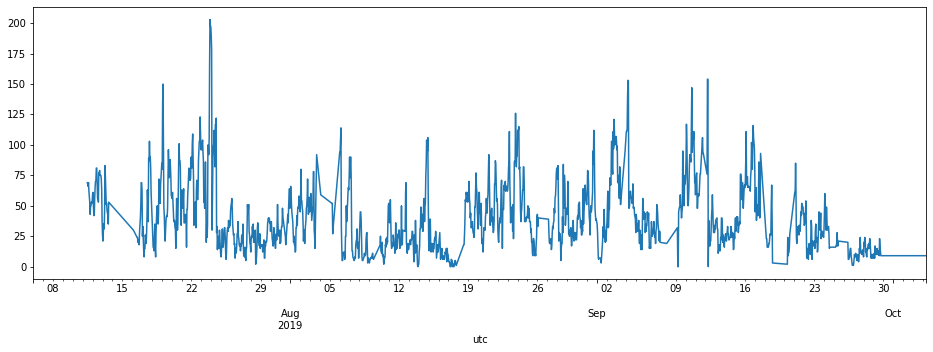

In [27]:
values = pd.Series(df_pm25["noida"], dtype="float")
values.index= pd.to_datetime(df_pm25["utc"])
plt.figure(figsize=(16, 5))
values.plot()

In [28]:
df_pm25[df_pm25["utc"]=="2019-08-20 00:00:00"]

##1080

,alipur,faridabad,ghaziabad,rohtak,noida,sonipat,utc
1080,52.409091,17.0,33.0,30.47,31.0,50.29,2019-08-20


In [29]:
df_pm25[df_pm25["utc"]=="2019-09-20 00:00:00"]

##1824

,alipur,faridabad,ghaziabad,rohtak,noida,sonipat,utc
1824,41.0,27.0,42.0,33.17,2.171429,32.53,2019-09-20


In [30]:
(1824-1080)*2/3 + 1080

1576.0

In [130]:
df_train=df_pm25[1080:1578]
df_test=df_pm25[1579:1824]

In [131]:
df_train.columns[:-1]

Index(['alipur', 'faridabad', 'ghaziabad', 'rohtak', 'noida', 'sonipat'], dtype='object')

In [132]:
df_train.head()

,alipur,faridabad,ghaziabad,rohtak,noida,sonipat,utc
1080,52.409091,17.0,33.0,30.47,31.0,50.29,2019-08-20 00:00:00
1081,53.272727,35.0,57.0,40.37,44.0,45.77,2019-08-20 01:00:00
1082,54.136364,30.0,52.0,29.93,61.0,47.26,2019-08-20 02:00:00
1083,55.000000,30.0,52.0,31.14,61.0,56.80,2019-08-20 03:00:00
1084,58.000000,30.0,60.0,35.81,44.0,53.82,2019-08-20 04:00:00


In [133]:
col

'sonipat'

In [134]:
df_train_shift=pd.DataFrame(columns=[""])
df_test_shift=pd.DataFrame(columns=[""])
for col in df_train.columns[:-1] :
    train_values = pd.Series(df_train["{}".format(col)], dtype="float")
    train_values.index= pd.to_datetime(df_train["utc"])
    test_values = pd.Series(df_test["{}".format(col)], dtype="float")
    test_values.index= pd.to_datetime(df_test["utc"])

    train_window = pd.DataFrame(train_values.values,index=train_values.index, columns=['{}'.format(col)])
    test_window = pd.DataFrame(test_values.values,index=test_values.index, columns=['{}'.format(col)])
    
    window = 36
    for i in range(1,window):
        train_window['{0}_{1}'.format(col, i)] = train_window['{}'.format(col)].shift(i)
        test_window['{0}_{1}'.format(col, i)] = test_window['{}'.format(col)].shift(i)
    
    df_train_shift = pd.concat([df_train_shift, train_window], axis=1)
    df_test_shift = pd.concat([df_test_shift, test_window], axis=1)
  

In [135]:
df_train_shift=df_train_shift.drop(df_train.columns[1:-1], axis=1).iloc[:,1:][window-1:]
df_test_shift=df_test_shift.drop(df_test.columns[1:-1], axis=1).iloc[:,1:][window-1:]

In [136]:
len(df_train_shift)

463

In [137]:
df_train_shift.head()

,alipur,alipur_1,alipur_2,alipur_3,alipur_4,alipur_5,alipur_6,alipur_7,alipur_8,alipur_9,...,sonipat_26,sonipat_27,sonipat_28,sonipat_29,sonipat_30,sonipat_31,sonipat_32,sonipat_33,sonipat_34,sonipat_35
2019-08-21 11:00:00,25.0,29.0,34.0,35.0,40.0,34.0,39.0,50.0,66.0,70.0,...,36.35,31.48,35.12,43.16,46.72,53.82,56.80,47.26,45.77,50.29
2019-08-21 12:00:00,27.0,25.0,29.0,34.0,35.0,40.0,34.0,39.0,50.0,66.0,...,32.37,36.35,31.48,35.12,43.16,46.72,53.82,56.80,47.26,45.77
2019-08-21 13:00:00,27.0,27.0,25.0,29.0,34.0,35.0,40.0,34.0,39.0,50.0,...,37.95,32.37,36.35,31.48,35.12,43.16,46.72,53.82,56.80,47.26
2019-08-21 14:00:00,30.0,27.0,27.0,25.0,29.0,34.0,35.0,40.0,34.0,39.0,...,34.33,37.95,32.37,36.35,31.48,35.12,43.16,46.72,53.82,56.80
2019-08-21 15:00:00,30.0,30.0,27.0,27.0,25.0,29.0,34.0,35.0,40.0,34.0,...,34.81,34.33,37.95,32.37,36.35,31.48,35.12,43.16,46.72,53.82


In [138]:
y_train = df_train_shift[['alipur']]
X_train = df_train_shift.drop('alipur', axis=1)
 
y_test = df_test_shift[['alipur']]
X_test = df_test_shift.drop('alipur', axis=1)

In [139]:
X_train=X_train[:-6]
y_train=y_train[6:]

X_test=X_test[:-6]
y_test=y_test[6:]

In [140]:
y_test.head()

,alipur
2019-09-11 12:00:00,91.000000
2019-09-11 13:00:00,89.833333
2019-09-11 14:00:00,88.666667
2019-09-11 15:00:00,87.500000
2019-09-11 16:00:00,86.333333


In [147]:

import lightgbm as lgb
train_data_set = lgb.Dataset(X_train, y_train)
test_data_set = lgb.Dataset(X_test, y_test, reference=train_data_set)
 
params = {                                                                                               
    'boosting_type': 'gbdt',                                                                             
    'objective': 'regression_l2',                                                                           
    'metric': 'l2',                                                                             
    'num_leaves': 40,                                                                                    
    'learning_rate': 0.05,                                                                               
    'feature_fraction': 0.9,                                                                             
    'bagging_fraction': 0.8,                                                                             
    'bagging_freq': 5,   
    'lambda_l2': 2,
}       


                                                                                                         
gbm = lgb.train(params,                                                                                  
                train_data_set,                                                                               
                num_boost_round=5000,                                                                      
                valid_sets=test_data_set,                                                                     
                early_stopping_rounds=3000
                )  


[1]	valid_0's l2: 430.231
Training until validation scores don't improve for 3000 rounds.
[2]	valid_0's l2: 426.329
[3]	valid_0's l2: 419.981
[4]	valid_0's l2: 418.888
[5]	valid_0's l2: 413.047
[6]	valid_0's l2: 405.586
[7]	valid_0's l2: 399.033
[8]	valid_0's l2: 389.962
[9]	valid_0's l2: 382.478
[10]	valid_0's l2: 376.328
[11]	valid_0's l2: 368.992
[12]	valid_0's l2: 366.671
[13]	valid_0's l2: 363.625
[14]	valid_0's l2: 362.628
[15]	valid_0's l2: 361.898
[16]	valid_0's l2: 361.308
[17]	valid_0's l2: 361.216
[18]	valid_0's l2: 360.05
[19]	valid_0's l2: 356.199
[20]	valid_0's l2: 356.254
[21]	valid_0's l2: 355.965
[22]	valid_0's l2: 354.899
[23]	valid_0's l2: 355.724
[24]	valid_0's l2: 356.872
[25]	valid_0's l2: 357.494
[26]	valid_0's l2: 353.696
[27]	valid_0's l2: 351.918
[28]	valid_0's l2: 349.269
[29]	valid_0's l2: 349.192
[30]	valid_0's l2: 345.467
[31]	valid_0's l2: 346.548
[32]	valid_0's l2: 346.831
[33]	valid_0's l2: 347.778
[34]	valid_0's l2: 349.738
[35]	valid_0's l2: 348.834
[

[298]	valid_0's l2: 394.572
[299]	valid_0's l2: 394.617
[300]	valid_0's l2: 395.044
[301]	valid_0's l2: 394.911
[302]	valid_0's l2: 394.908
[303]	valid_0's l2: 394.217
[304]	valid_0's l2: 394.129
[305]	valid_0's l2: 393.917
[306]	valid_0's l2: 393.577
[307]	valid_0's l2: 393.557
[308]	valid_0's l2: 393.221
[309]	valid_0's l2: 392.679
[310]	valid_0's l2: 392.419
[311]	valid_0's l2: 392.399
[312]	valid_0's l2: 392.502
[313]	valid_0's l2: 392.674
[314]	valid_0's l2: 391.974
[315]	valid_0's l2: 391.857
[316]	valid_0's l2: 391.537
[317]	valid_0's l2: 391.322
[318]	valid_0's l2: 391.256
[319]	valid_0's l2: 391.192
[320]	valid_0's l2: 391.141
[321]	valid_0's l2: 391.111
[322]	valid_0's l2: 391.202
[323]	valid_0's l2: 391.077
[324]	valid_0's l2: 390.262
[325]	valid_0's l2: 390.206
[326]	valid_0's l2: 390.224
[327]	valid_0's l2: 390.295
[328]	valid_0's l2: 390.578
[329]	valid_0's l2: 390.756
[330]	valid_0's l2: 391.021
[331]	valid_0's l2: 390.858
[332]	valid_0's l2: 390.784
[333]	valid_0's l2: 

[600]	valid_0's l2: 400.39
[601]	valid_0's l2: 400.774
[602]	valid_0's l2: 401.076
[603]	valid_0's l2: 400.975
[604]	valid_0's l2: 400.865
[605]	valid_0's l2: 401.083
[606]	valid_0's l2: 400.887
[607]	valid_0's l2: 400.703
[608]	valid_0's l2: 400.537
[609]	valid_0's l2: 400.427
[610]	valid_0's l2: 400.199
[611]	valid_0's l2: 400.07
[612]	valid_0's l2: 399.88
[613]	valid_0's l2: 399.688
[614]	valid_0's l2: 399.741
[615]	valid_0's l2: 399.635
[616]	valid_0's l2: 399.533
[617]	valid_0's l2: 399.356
[618]	valid_0's l2: 399.154
[619]	valid_0's l2: 399.577
[620]	valid_0's l2: 399.503
[621]	valid_0's l2: 399.53
[622]	valid_0's l2: 399.552
[623]	valid_0's l2: 399.611
[624]	valid_0's l2: 399.573
[625]	valid_0's l2: 399.606
[626]	valid_0's l2: 399.62
[627]	valid_0's l2: 399.847
[628]	valid_0's l2: 399.978
[629]	valid_0's l2: 399.838
[630]	valid_0's l2: 400.136
[631]	valid_0's l2: 400.118
[632]	valid_0's l2: 399.987
[633]	valid_0's l2: 400.001
[634]	valid_0's l2: 399.974
[635]	valid_0's l2: 399.7

[914]	valid_0's l2: 400.573
[915]	valid_0's l2: 400.52
[916]	valid_0's l2: 400.424
[917]	valid_0's l2: 400.351
[918]	valid_0's l2: 400.326
[919]	valid_0's l2: 400.271
[920]	valid_0's l2: 400.27
[921]	valid_0's l2: 400.226
[922]	valid_0's l2: 400.184
[923]	valid_0's l2: 400.201
[924]	valid_0's l2: 400.197
[925]	valid_0's l2: 400.23
[926]	valid_0's l2: 400.368
[927]	valid_0's l2: 400.404
[928]	valid_0's l2: 400.337
[929]	valid_0's l2: 400.492
[930]	valid_0's l2: 400.429
[931]	valid_0's l2: 400.6
[932]	valid_0's l2: 400.605
[933]	valid_0's l2: 400.602
[934]	valid_0's l2: 400.557
[935]	valid_0's l2: 400.76
[936]	valid_0's l2: 400.717
[937]	valid_0's l2: 400.665
[938]	valid_0's l2: 400.599
[939]	valid_0's l2: 400.628
[940]	valid_0's l2: 400.589
[941]	valid_0's l2: 400.746
[942]	valid_0's l2: 400.904
[943]	valid_0's l2: 401.112
[944]	valid_0's l2: 401.014
[945]	valid_0's l2: 400.961
[946]	valid_0's l2: 401.141
[947]	valid_0's l2: 401.348
[948]	valid_0's l2: 401.481
[949]	valid_0's l2: 401.66

[1207]	valid_0's l2: 400.966
[1208]	valid_0's l2: 400.968
[1209]	valid_0's l2: 400.961
[1210]	valid_0's l2: 400.916
[1211]	valid_0's l2: 400.834
[1212]	valid_0's l2: 400.758
[1213]	valid_0's l2: 400.733
[1214]	valid_0's l2: 400.71
[1215]	valid_0's l2: 400.65
[1216]	valid_0's l2: 400.845
[1217]	valid_0's l2: 400.78
[1218]	valid_0's l2: 400.983
[1219]	valid_0's l2: 400.924
[1220]	valid_0's l2: 401.011
[1221]	valid_0's l2: 400.959
[1222]	valid_0's l2: 400.856
[1223]	valid_0's l2: 400.825
[1224]	valid_0's l2: 400.771
[1225]	valid_0's l2: 400.706
[1226]	valid_0's l2: 400.686
[1227]	valid_0's l2: 400.686
[1228]	valid_0's l2: 400.663
[1229]	valid_0's l2: 400.636
[1230]	valid_0's l2: 400.626
[1231]	valid_0's l2: 400.583
[1232]	valid_0's l2: 400.535
[1233]	valid_0's l2: 400.734
[1234]	valid_0's l2: 400.673
[1235]	valid_0's l2: 400.772
[1236]	valid_0's l2: 400.768
[1237]	valid_0's l2: 400.733
[1238]	valid_0's l2: 400.681
[1239]	valid_0's l2: 400.671
[1240]	valid_0's l2: 400.624
[1241]	valid_0's 

[1491]	valid_0's l2: 400.941
[1492]	valid_0's l2: 400.899
[1493]	valid_0's l2: 400.873
[1494]	valid_0's l2: 400.885
[1495]	valid_0's l2: 400.906
[1496]	valid_0's l2: 400.861
[1497]	valid_0's l2: 400.857
[1498]	valid_0's l2: 400.848
[1499]	valid_0's l2: 400.829
[1500]	valid_0's l2: 400.828
[1501]	valid_0's l2: 400.788
[1502]	valid_0's l2: 400.886
[1503]	valid_0's l2: 400.835
[1504]	valid_0's l2: 400.812
[1505]	valid_0's l2: 400.903
[1506]	valid_0's l2: 401.004
[1507]	valid_0's l2: 400.976
[1508]	valid_0's l2: 401.06
[1509]	valid_0's l2: 401.148
[1510]	valid_0's l2: 401.086
[1511]	valid_0's l2: 401.058
[1512]	valid_0's l2: 401.028
[1513]	valid_0's l2: 401.122
[1514]	valid_0's l2: 401.124
[1515]	valid_0's l2: 401.097
[1516]	valid_0's l2: 401.044
[1517]	valid_0's l2: 401.005
[1518]	valid_0's l2: 400.959
[1519]	valid_0's l2: 400.944
[1520]	valid_0's l2: 400.932
[1521]	valid_0's l2: 401.038
[1522]	valid_0's l2: 401.108
[1523]	valid_0's l2: 401.041
[1524]	valid_0's l2: 401.143
[1525]	valid_0'

[1792]	valid_0's l2: 400.919
[1793]	valid_0's l2: 400.907
[1794]	valid_0's l2: 400.885
[1795]	valid_0's l2: 400.866
[1796]	valid_0's l2: 400.816
[1797]	valid_0's l2: 400.853
[1798]	valid_0's l2: 400.81
[1799]	valid_0's l2: 400.781
[1800]	valid_0's l2: 400.758
[1801]	valid_0's l2: 400.761
[1802]	valid_0's l2: 400.774
[1803]	valid_0's l2: 400.766
[1804]	valid_0's l2: 400.76
[1805]	valid_0's l2: 400.739
[1806]	valid_0's l2: 400.797
[1807]	valid_0's l2: 400.775
[1808]	valid_0's l2: 400.821
[1809]	valid_0's l2: 400.78
[1810]	valid_0's l2: 400.867
[1811]	valid_0's l2: 400.828
[1812]	valid_0's l2: 400.829
[1813]	valid_0's l2: 400.806
[1814]	valid_0's l2: 400.806
[1815]	valid_0's l2: 400.82
[1816]	valid_0's l2: 400.816
[1817]	valid_0's l2: 400.81
[1818]	valid_0's l2: 400.803
[1819]	valid_0's l2: 400.8
[1820]	valid_0's l2: 400.803
[1821]	valid_0's l2: 400.885
[1822]	valid_0's l2: 400.976
[1823]	valid_0's l2: 401.054
[1824]	valid_0's l2: 401.145
[1825]	valid_0's l2: 401.2
[1826]	valid_0's l2: 40

[2097]	valid_0's l2: 401.06
[2098]	valid_0's l2: 401.093
[2099]	valid_0's l2: 401.068
[2100]	valid_0's l2: 401.038
[2101]	valid_0's l2: 401.12
[2102]	valid_0's l2: 401.194
[2103]	valid_0's l2: 401.27
[2104]	valid_0's l2: 401.248
[2105]	valid_0's l2: 401.29
[2106]	valid_0's l2: 401.263
[2107]	valid_0's l2: 401.241
[2108]	valid_0's l2: 401.213
[2109]	valid_0's l2: 401.179
[2110]	valid_0's l2: 401.16
[2111]	valid_0's l2: 401.138
[2112]	valid_0's l2: 401.11
[2113]	valid_0's l2: 401.094
[2114]	valid_0's l2: 401.074
[2115]	valid_0's l2: 401.059
[2116]	valid_0's l2: 401.074
[2117]	valid_0's l2: 401.092
[2118]	valid_0's l2: 401.098
[2119]	valid_0's l2: 401.14
[2120]	valid_0's l2: 401.156
[2121]	valid_0's l2: 401.198
[2122]	valid_0's l2: 401.232
[2123]	valid_0's l2: 401.211
[2124]	valid_0's l2: 401.191
[2125]	valid_0's l2: 401.229
[2126]	valid_0's l2: 401.213
[2127]	valid_0's l2: 401.249
[2128]	valid_0's l2: 401.245
[2129]	valid_0's l2: 401.241
[2130]	valid_0's l2: 401.282
[2131]	valid_0's l2: 

[2419]	valid_0's l2: 400.968
[2420]	valid_0's l2: 400.971
[2421]	valid_0's l2: 400.974
[2422]	valid_0's l2: 400.975
[2423]	valid_0's l2: 400.973
[2424]	valid_0's l2: 400.969
[2425]	valid_0's l2: 400.977
[2426]	valid_0's l2: 400.972
[2427]	valid_0's l2: 400.967
[2428]	valid_0's l2: 401.007
[2429]	valid_0's l2: 401.003
[2430]	valid_0's l2: 400.998
[2431]	valid_0's l2: 401.033
[2432]	valid_0's l2: 401.031
[2433]	valid_0's l2: 401.067
[2434]	valid_0's l2: 401.062
[2435]	valid_0's l2: 401.049
[2436]	valid_0's l2: 401.05
[2437]	valid_0's l2: 401.051
[2438]	valid_0's l2: 401.049
[2439]	valid_0's l2: 401.054
[2440]	valid_0's l2: 401.051
[2441]	valid_0's l2: 401.083
[2442]	valid_0's l2: 401.076
[2443]	valid_0's l2: 401.109
[2444]	valid_0's l2: 401.139
[2445]	valid_0's l2: 401.124
[2446]	valid_0's l2: 401.121
[2447]	valid_0's l2: 401.101
[2448]	valid_0's l2: 401.097
[2449]	valid_0's l2: 401.081
[2450]	valid_0's l2: 401.071
[2451]	valid_0's l2: 401.056
[2452]	valid_0's l2: 401.046
[2453]	valid_0'

[2749]	valid_0's l2: 401.186
[2750]	valid_0's l2: 401.205
[2751]	valid_0's l2: 401.194
[2752]	valid_0's l2: 401.182
[2753]	valid_0's l2: 401.171
[2754]	valid_0's l2: 401.165
[2755]	valid_0's l2: 401.151
[2756]	valid_0's l2: 401.146
[2757]	valid_0's l2: 401.14
[2758]	valid_0's l2: 401.136
[2759]	valid_0's l2: 401.131
[2760]	valid_0's l2: 401.123
[2761]	valid_0's l2: 401.12
[2762]	valid_0's l2: 401.118
[2763]	valid_0's l2: 401.112
[2764]	valid_0's l2: 401.109
[2765]	valid_0's l2: 401.114
[2766]	valid_0's l2: 401.113
[2767]	valid_0's l2: 401.109
[2768]	valid_0's l2: 401.104
[2769]	valid_0's l2: 401.097
[2770]	valid_0's l2: 401.094
[2771]	valid_0's l2: 401.091
[2772]	valid_0's l2: 401.092
[2773]	valid_0's l2: 401.087
[2774]	valid_0's l2: 401.086
[2775]	valid_0's l2: 401.083
[2776]	valid_0's l2: 401.1
[2777]	valid_0's l2: 401.12
[2778]	valid_0's l2: 401.116
[2779]	valid_0's l2: 401.135
[2780]	valid_0's l2: 401.154
[2781]	valid_0's l2: 401.149
[2782]	valid_0's l2: 401.144
[2783]	valid_0's l2

In [148]:
y_train_lgbpred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_test_lgbpred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [149]:
# MSE
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, y_train_lgbpred), mean_squared_error(y_test, y_test_lgbpred)) )
# R^2
from sklearn.metrics import r2_score
print('R^2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_lgbpred), r2_score(y_test, y_test_lgbpred)) )

MSE train : 77.205, test : 340.436
R^2 train : 0.816, test : 0.211


In [150]:
# XGboostのライブラリをインポート
import xgboost as xgb
# モデルのインスタンス作成
mod = xgb.XGBRegressor()
mod.fit(X_train, y_train)

[11:06:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [151]:
y_train_pred= mod.predict(X_train)
y_test_pred = mod.predict(X_test)

In [152]:
# MSE
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)) )
# R^2
from sklearn.metrics import r2_score
print('R^2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)) )

MSE train : 12.405, test : 424.520
R^2 train : 0.970, test : 0.016


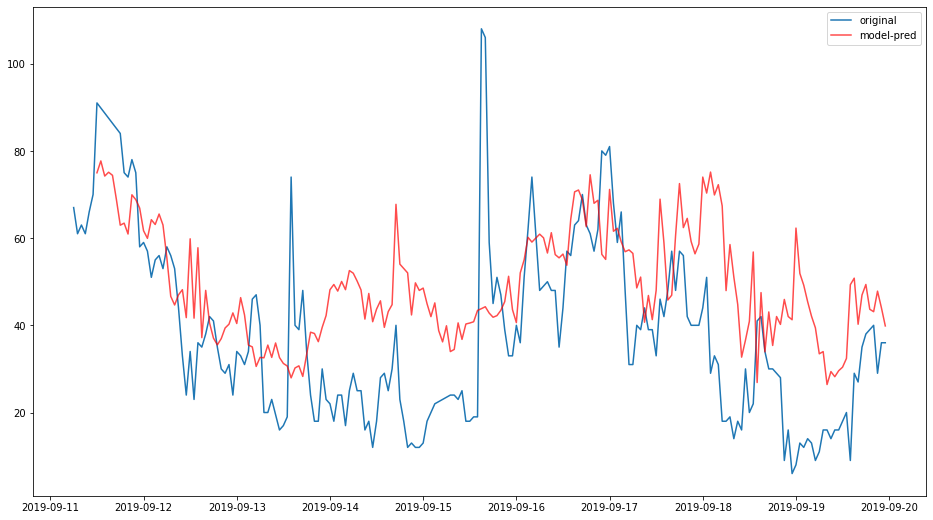

In [153]:
plot_y_test = y_test
plot_y_test["alipur"] = y_test_pred


plt.figure(figsize=(16, 9))
plt.plot(df_test_shift["alipur"], label="original")
plt.plot(plot_y_test, c="r", label="model-pred", alpha=0.7)
plt.legend(loc='best')

In [154]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         "colsample_bytree": [0.5,1.0],
         }
# モデルにインスタンス生成
mod = xgb.XGBRegressor()
# ハイパーパラメータ探索
cv = GridSearchCV(mod, params, cv = 10, n_jobs =-1)

In [155]:
cv.fit(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[11:13:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1.0],
                         'learning_rate': [0.1, 0.3, 0.5],
       

In [156]:
y_train_newpred= cv.predict(X_train)
y_test_newpred = cv.predict(X_test)

In [157]:
# MSE
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, y_train_newpred), mean_squared_error(y_test, y_test_newpred)) )
# R^2
from sklearn.metrics import r2_score
print('R^2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_newpred), r2_score(y_test, y_test_newpred)) )

MSE train : 0.886, test : 48.563
R^2 train : 0.998, test : 0.685


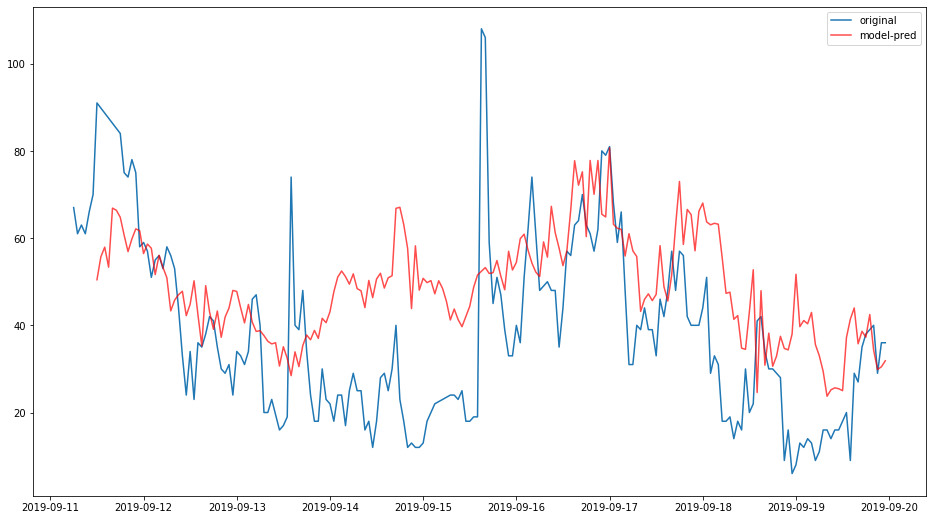

In [158]:
plot_y_newtest = y_test
plot_y_newtest["alipur"] = y_test_newpred

#test_values = pd.DataFrame(test_values.values, index=test_values.index, columns=['alipur'])


plt.figure(figsize=(16, 9))
plt.plot(df_test_shift["alipur"], label="original")
plt.plot(plot_y_newtest, c="r", label="model-pred", alpha=0.7)
plt.legend(loc='best')

In [91]:
df_test_shift["alipur"]

2019-09-10 18:00:00    68.0
2019-09-10 19:00:00    64.0
2019-09-10 20:00:00    59.0
2019-09-10 21:00:00    61.0
2019-09-10 22:00:00    66.0
                       ... 
2019-09-19 19:00:00    39.0
2019-09-19 20:00:00    40.0
2019-09-19 21:00:00    29.0
2019-09-19 22:00:00    36.0
2019-09-19 23:00:00    36.0
Name: alipur, Length: 222, dtype: float64

In [99]:
test_values

utc
2019-09-09 19:00:00    69.71
2019-09-09 20:00:00    67.56
2019-09-09 21:00:00    81.51
2019-09-09 22:00:00    91.28
2019-09-09 23:00:00    89.11
                       ...  
2019-09-19 19:00:00    35.52
2019-09-19 20:00:00    31.56
2019-09-19 21:00:00    26.22
2019-09-19 22:00:00    34.97
2019-09-19 23:00:00    33.08
Name: sonipat, Length: 245, dtype: float64